# Import Python Packages

In [ ]:
import json
import pandas as pd
import math
from tqdm import tqdm 
import cv2
import numpy as np
import os

import torch 
import torchvision
import torch.nn as nn 
from IPython.display import Image 
from torchvision import transforms
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 12345
random.seed(seed)
torch.manual_seed(seed)
import PIL
import requests
  
from sklearn import decomposition    
from sklearn.preprocessing import MinMaxScaler

# Load Data

synthetic aircraft dataset

In [ ]:
coco_dir = "/content/drive/MyDrive/111 Rendered.ai/RarePlanes/datasets/synthetic/instances_test_aircraft.json"
images_dir = "/content/drive/MyDrive/111 Rendered.ai/RarePlanes/datasets/synthetic/test/images/"
test_json_dir = coco_dir
with open(test_json_dir) as json_file:
    test_coco = json.load(json_file)
    
print(test_coco.keys())
print("Num images:{}".format(len(test_coco['images'])))
print("Num classes:{}".format(len(test_coco['categories'])))
print("Num bbox/instances:{}".format(len(test_coco['annotations'])))

dict_keys(['categories', 'images', 'annotations', 'licenses', 'info'])
Num images:5000
Num classes:1
Num bbox/instances:62841


In [ ]:
img_list = pd.DataFrame(test_coco['images'])
img_list.head()

annotations = pd.DataFrame(test_coco['annotations'])
annotations.head()

ann = annotations.merge(img_list, how='left', left_on="image_id", right_on="id")
ann.shape

(62841, 17)

In [ ]:
# ann.to_csv("./instance_annotations_synthetic_test.csv")

In [ ]:
ann.shape

(62841, 17)

# Crop bbox

In [ ]:
def crop_image(file_name, bbox):
    dir = "/content/drive/MyDrive/111 Rendered.ai/RarePlanes/datasets/synthetic/test/images/"
    ori_img_dir = dir+file_name
    my_image = cv2.imread(ori_img_dir)
    buffer=0
    cropped_im = my_image[math.floor(bbox[1]) - buffer : math.floor(bbox[1]) + math.ceil(bbox[3]) + buffer,
                          math.floor(bbox[0]) - buffer : math.floor(bbox[0]) + math.ceil(bbox[2]) + buffer,:]
    return cropped_im


def upsampling(crop_im, max_shape):
    crop_im = crop_im.view(1,crop_im.shape[0],crop_im.shape[1],crop_im.shape[2]).permute(0,3,1,2)
    # print(crop_im.shape)
    upsampler = nn.Upsample(size=(max_shape[0], max_shape[1]), mode="nearest")
    upsampled_crop_im = upsampler(crop_im)
    # print(upsampled_crop_im.shape)
    return upsampled_crop_im

In [ ]:
# save all bbox
n_instances = ann.shape[0]
for i in tqdm(range(n_instances)):
    instance = ann.iloc[i]
    file_name = instance['file_name']
    bbox = instance['bbox']
    cropped_im = crop_image(file_name, bbox)
    # save cropped images
    save_dir = "/content/drive/MyDrive/111 Rendered.ai/data/cropped_synthetic_images/"
    np.save(save_dir+str(i)+"_"+str(file_name)[:-4], cropped_im)

In [ ]:
# save all bbox
n_instances_sample = 500
crop_ims = []
for i in tqdm(range(n_instances_sample)):
    instance = ann.iloc[i]
    file_name = instance['file_name']
    bbox = instance['bbox']
    cropped_im = crop_image(file_name, bbox)
    crop_ims.append(cropped_im)

crop_ims_shape = [im.shape for im in crop_ims]
max_shape, min_shape = max(crop_ims_shape),min(crop_ims_shape)
print(min_shape, max_shape)

In [ ]:
img_collection = []
for i in tqdm(range(len(crop_ims))):
    output_size = [max(max_shape),max(max_shape),3]
    upsampled_crop_im = upsampling(torch.tensor(crop_ims[i]), output_size)
    upsampled_crop_im = upsampled_crop_im.permute(0,2,3,1)
    img_collection.append(upsampled_crop_im)

# Load BBOX

In [ ]:
cd /content/drive/MyDrive/111 Rendered.ai/data/cropped_synthetic_images/

/content/drive/MyDrive/111 Rendered.ai/data/cropped_synthetic_images


In [ ]:
crop_ims = []
for f in os.listdir(os.getcwd()):
   crop_ims.append(torch.tensor(np.load(f)))

In [ ]:
crop_ims_shape = [im.shape for im in crop_ims]
max_shape, min_shape = max(crop_ims_shape),min(crop_ims_shape)
print(min_shape, max_shape)

torch.Size([16, 28, 3]) torch.Size([170, 211, 3])


In [ ]:

img_collection = []
for i in tqdm(range(len(crop_ims))):
    output_size = [max(max_shape),max(max_shape),3]
    upsampled_crop_im = upsampling(crop_ims[i], output_size)
    img_collection.append(upsampled_crop_im)

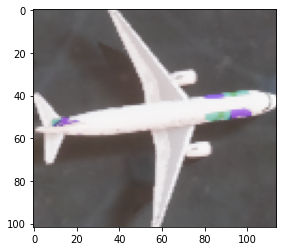

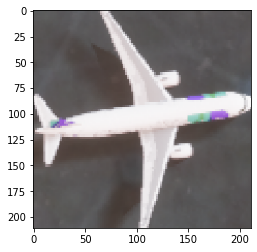

In [ ]:
plt.imshow(crop_ims[i]);plt.show();
plt.imshow(upsampled_crop_im[0].permute(1,2,0))

# PCA

In [ ]:
# load data
num_samples, width, height, n_channel = data.shape
data = np.concatenate(img_collection)
print("Data shape:{}".format(data.shape))

# flatten the img
flat_data = data.reshape(num_samples, -1)
print("flattened data shape:{}".format(flat_data.shape))
n_samples, n_features = flat_data.shape

# centering
min_max_scaler = MinMaxScaler()
flat_data_centered = min_max_scaler.fit_transform(flat_data)
print("flattened centered data shape:{}".format(flat_data_centered.shape))
print(flat_data_centered.min(), flat_data_centered.max())

Data shape:(500, 248, 248, 3)
flattened data shape:(500, 184512)
flattened centered data shape:(500, 184512)
0.0 1.0000000000000002


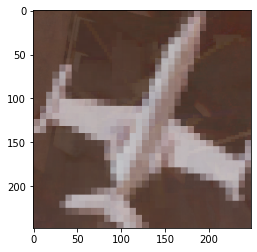

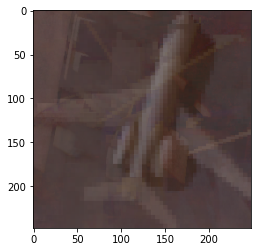

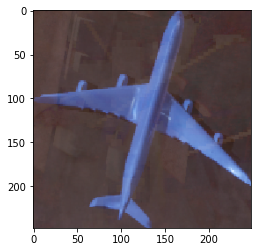

In [ ]:
for i in range(3):
  plt.imshow(flat_data_centered[i].reshape(width, height, n_channel));plt.show()

In [ ]:
#Reducing dimension into n components
n_components_ = 9
pca = decomposition.PCA(n_components=n_components_, whiten=True)
pca.fit(flat_data_centered)

PCA(copy=True, iterated_power='auto', n_components=9, random_state=None,
    svd_solver='auto', tol=0.0, whiten=True)

[0.58373977 0.6200311  0.63998507 0.65786577 0.67470093 0.69013676
 0.70343082 0.71552629 0.72655041]


0.7265504056076996

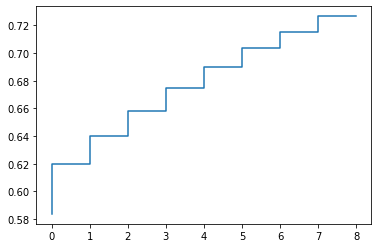

In [ ]:
#Cumulative sum of varience ratio of all components
exp_var_cum=np.cumsum(pca.explained_variance_ratio_)
print(exp_var_cum)
plt.step(range(exp_var_cum.size), exp_var_cum)
exp_var_cum[8]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0016981767497162706 0.0028681959842631567
-0.0030769590260468845 0.007977004155392719
-0.006485052378706928 0.006605419252804977
-0.007992317181123343 0.007481222344876119
-0.007884211775888383 0.0077774320193515385
-0.0059763173537696 0.006401075219648584
-0.007313745968706272 0.008801044110344455
-0.006841012155810899 0.008559613100326654
-0.006050279942314911 0.009553585942981127


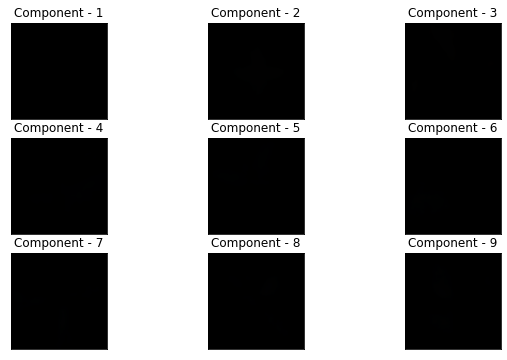

In [ ]:
#Lets see the components from PCA
fig, ax = plt.subplots(3,3, figsize=(10,6), subplot_kw={'xticks':(), 'yticks': ()})
ax = ax.ravel()
for i in range(9):
    pixels = pca.components_[i].reshape(width, height, n_channel)
    # print(pixels.min(),pixels.max())
    pixels_rgb = (pixels * 255).astype(np.uint8) # turn output into rgb channel 
    ax[i].imshow(pixels, cmap='viridis')
    ax[i].set_title("Component - " + str(i+1))

# NMF

reference: http://www.columbia.edu/~jwp2128/Teaching/E4903/papers/nmf_nature.pdf

In [ ]:
# load data
num_samples, width, height, n_channel = data.shape
data = np.concatenate(img_collection)
print("Data shape:{}".format(data.shape))

# flatten the img
flat_data = data.reshape(num_samples, -1)
print("flattened data shape:{}".format(flat_data.shape))
n_samples, n_features = flat_data.shape

# centering
min_max_scaler = MinMaxScaler()
flat_data_centered = min_max_scaler.fit_transform(flat_data)
print("flattened centered data shape:{}".format(flat_data_centered.shape))
# print(flat_data_centered.min(), flat_data_centered.max())

Data shape:(500, 248, 248, 3)
flattened data shape:(500, 184512)
flattened centered data shape:(500, 184512)


In [ ]:
#Reducing dimension into n components
n_components = 24
nmf = decomposition.NMF(n_components = n_components, init = 'random', tol=5e-3)    
W = nmf.fit_transform(flat_data_centered)
H = nmf.components_

In [ ]:
data.shape, flat_data_centered.shape, W.shape, H.shape

((500, 248, 248, 3), (500, 184512), (500, 24), (24, 184512))

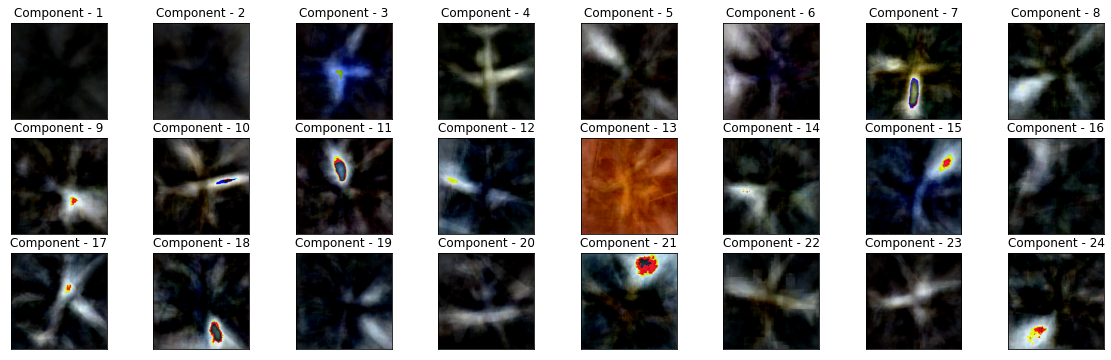

In [ ]:
# Lets see the components from NMF
fig, ax = plt.subplots(3, 8, figsize=(20,6), subplot_kw={'xticks':(), 'yticks': ()})
ax = ax.ravel()
for i in range(24):
    pixels = H[i]
    # print(pixels.min(), pixels.max())
    pixels = pixels.reshape(width, height, n_channel)
    pixels_rgb = (pixels * 255).astype(np.uint8) # turn output into rgb channel 
    ax[i].imshow(pixels_rgb)
    ax[i].set_title("Component - " + str(i+1))

## Tuning k number of components

In [ ]:
# tuning k num_components
losses=[]
Hs = []
max_components = 30
for k in tqdm(range(2,max_components)):
    nmf = decomposition.NMF(n_components = k, init = 'random', tol=5e-3)    
    W = nmf.fit_transform(flat_data_centered)
    H = nmf.components_
    Hs.append(H)
    loss = np.linalg.norm(W.dot(H)-flat_data_centered)
    losses.append(loss)

Text(0.5, 0, 'k: Number of Components')

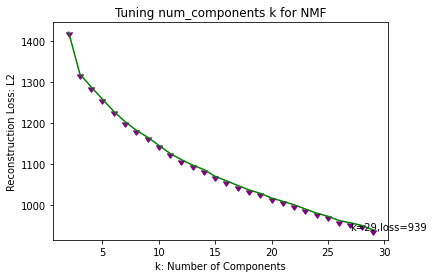

In [ ]:
plt.plot(range(2,30), losses, color="green")
plt.scatter(range(2,30), losses, marker=11, color="purple")
a=np.array(losses);
min_indx=np.argmin(a)#min value index
show_min='k='+str(min_indx+2)+',loss='+str(a[min_indx])[:3]
plt.annotate(show_min,xytext=(min_indx,a[min_indx]),xy=(min_indx,a[min_indx]))
plt.title("Tuning num_components k for NMF")
plt.ylabel("Reconstruction Loss: L2")
plt.xlabel("k: Number of Components")

In [ ]:
losses[22]

980.120627054412

k=24

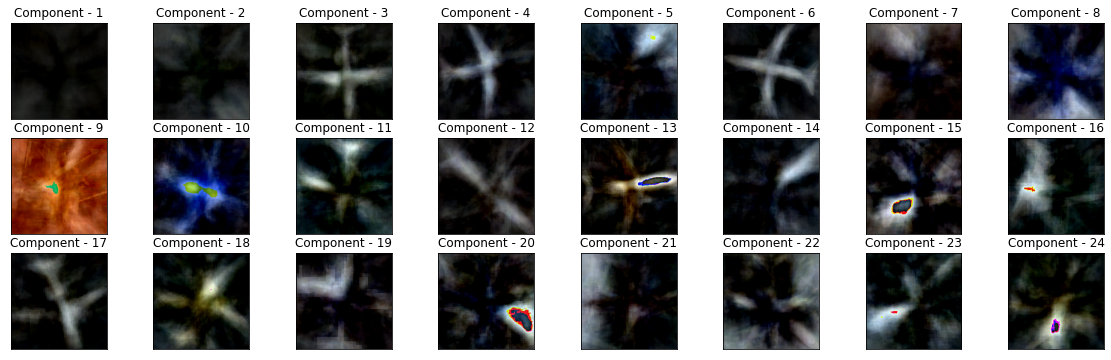

In [ ]:
# Lets see the components from NMF
fig, ax = plt.subplots(3, 8, figsize=(20,6), subplot_kw={'xticks':(), 'yticks': ()})
ax = ax.ravel()
H = Hs[22]
for i in range(24):
    pixels = H[i]
    # print(pixels.min(), pixels.max())
    pixels = pixels.reshape(width, height, n_channel)
    pixels_rgb = (pixels * 255).astype(np.uint8) # turn output into rgb channel 
    ax[i].imshow(pixels_rgb)
    ax[i].set_title("Component - " + str(i+1))

k=29

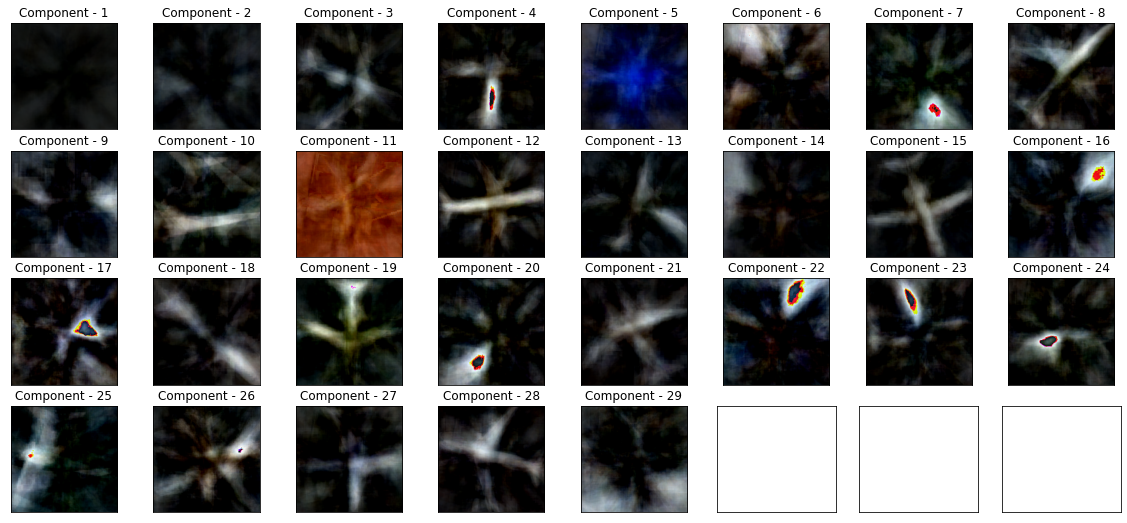

In [ ]:
# Lets see the components from NMF
fig, ax = plt.subplots(4, 8, figsize=(20,9), subplot_kw={'xticks':(), 'yticks': ()})
ax = ax.ravel()
H = Hs[min_indx]
for i in range(min_indx+2):
    pixels = H[i]
    # print(pixels.min(), pixels.max())
    pixels = pixels.reshape(width, height, n_channel)
    pixels_rgb = (pixels * 255).astype(np.uint8) # turn output into rgb channel 
    ax[i].imshow(pixels_rgb)
    ax[i].set_title("Component - " + str(i+1))

k=9

In [ ]:
losses[7]

1165.4367318331917

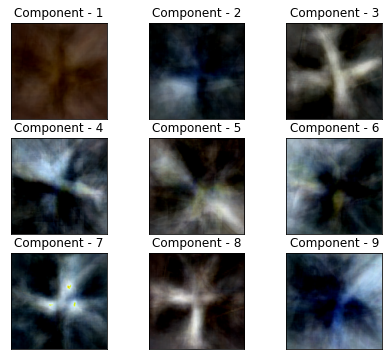

In [ ]:
# Lets see the components from NMF
fig, ax = plt.subplots(3, 3, figsize=(7,6), subplot_kw={'xticks':(), 'yticks': ()})
ax = ax.ravel()
H = Hs[7]
for i in range(9):
    pixels = H[i]
    # print(pixels.min(), pixels.max())
    pixels = pixels.reshape(width, height, n_channel)
    pixels_rgb = (pixels * 255).astype(np.uint8) # turn output into rgb channel 
    ax[i].imshow(pixels_rgb)
    ax[i].set_title("Component - " + str(i+1))